# **Homework 1: Linear Regression**

本次目標：由前 9 個小時的 18 個 features (包含 PM2.5)預測的 10 個小時的 PM2.5。<!-- 可以參考 <link> 獲知更細項的作業說明。-->

<!-- 首先，從 https://drive.google.com/open?id=1El0zvTkrSuqCTDcMpijXpADvJzZC2Jpa 將整個資料夾下載下來，並將下載下來的資料夾放到自己的 Google Drive（注意：上傳到自己 Google Drive 的是資料夾 hw1-regression，而非壓縮檔） -->


若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# **Load 'train.csv'**
train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

In [20]:
import sys
import pandas as pd
import numpy as np
from google.colab import drive 
!gdown --id '1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm' --output data.zip
!unzip data.zip
# data = pd.read_csv('gdrive/My Drive/hw1-regression/train.csv', header = None, encoding = 'big5')
data = pd.read_csv('./train.csv', encoding = 'big5')

Downloading...
From: https://drive.google.com/uc?id=1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm
To: /content/data.zip
100% 177k/177k [00:00<00:00, 67.2MB/s]
Archive:  data.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [21]:
data

,日期,測站,測項,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2014/1/1,豐原,AMB_TEMP,14,14,14,13,12,12,12,12,15,17,20,22,22,22,22,22,21,19,17,16,15,15,15,15
1,2014/1/1,豐原,CH4,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
2,2014/1/1,豐原,CO,0.51,0.41,0.39,0.37,0.35,0.3,0.37,0.47,0.78,0.74,0.59,0.52,0.41,0.4,0.37,0.37,0.47,0.69,0.56,0.45,0.38,0.35,0.36,0.32
3,2014/1/1,豐原,NMHC,0.2,0.15,0.13,0.12,0.11,0.06,0.1,0.13,0.26,0.23,0.2,0.18,0.12,0.11,0.1,0.13,0.14,0.23,0.18,0.12,0.1,0.09,0.1,0.08
4,2014/1/1,豐原,NO,0.9,0.6,0.5,1.7,1.8,1.5,1.9,2.2,6.6,7.9,4.2,2.9,3.4,3,2.5,2.2,2.5,2.3,2.1,1.9,1.5,1.6,1.8,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2014/12/20,豐原,THC,1.8,1.8,1.8,1.8,1.8,1.7,1.7,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,2,2.1,2,1.9,1.9,1.9,2,2
4316,2014/12/20,豐原,WD_HR,46,13,61,44,55,68,66,70,66,85,67,60,61,60,59,308,327,21,100,109,108,114,108,109
4317,2014/12/20,豐原,WIND_DIREC,36,55,72,327,74,52,59,83,106,105,60,62,58,75,18,311,52,54,121,97,107,118,100,105
4318,2014/12/20,豐原,WIND_SPEED,1.9,2.4,1.9,2.8,2.3,1.9,2.1,3.7,2.8,3.8,4.1,3.2,3.1,2.8,2.3,2.6,1.3,1,1.5,1,1.7,1.5,2,2


# **Preprocessing** 
取需要的數值部分，將 'RAINFALL' 欄位全部補 0。
另外，如果要在 colab 重覆這段程式碼的執行，請從頭開始執行(把上面的都重新跑一次)，以避免跑出不是自己要的結果（若自己寫程式不會遇到，但 colab 重複跑這段會一直往下取資料。意即第一次取原本資料的第三欄之後的資料，第二次取第一次取的資料掉三欄之後的資料，...）。

In [22]:
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


# **Extract Features (1)**
![圖片說明](https://drive.google.com/uc?id=1LyaqD4ojX07oe5oDzPO99l9ts5NRyArH)
![圖片說明](https://drive.google.com/uc?id=1ZroBarcnlsr85gibeqEF-MtY13xJTG47)

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。 

In [23]:
month_data = {}
for month in range(12):
    sample = np.empty([18, 480]) # 共一個月
    for day in range(20):   #共一天
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample

# **Extract Features (2)**
![alt text](https://drive.google.com/uc?id=1wKoPuaRHoX682LMiBgIoOP4PDyNKsJLK)
![alt text](https://drive.google.com/uc?id=1FRWWiXQ-Qh0i9tyx0LiugHYF_xDdkhLN)

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

In [24]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14: # 當第20天的第14個window時，離開迴圈，不執行下方程式碼
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value
print(x.shape)
print(y.shape)

(5652, 162)
(5652, 1)


# **Normalize (1)**


In [25]:
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

#**Split Training Data Into "train_set" and "validation_set"**
這部分是針對作業中 report 的第二題、第三題做的簡單示範，以生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

In [26]:
import math
x_train_set = x[: math.floor(len(x) * 0.8), :]  # floor 回傳小於等於所給數字的最大整數
y_train_set = y[: math.floor(len(y) * 0.8), :]  # train (80%  
x_validation = x[math.floor(len(x) * 0.8): , :]  # val(20%
y_validation = y[math.floor(len(y) * 0.8): , :]

print(x_train_set.shape)
print(x_validation.shape)


(4521, 162)
(1131, 162)


# **Training**
![alt text](https://drive.google.com/uc?id=1xIXvqZ4EGgmxrp7c9r0LOVbcvd4d9H4N)
![alt text](https://drive.google.com/uc?id=1S42g06ON5oJlV2f9RukxawjbE4NpsaB6)
![alt text](https://drive.google.com/uc?id=1BbXu-oPB9EZBHDQ12YCkYqtyAIil3bGj)

(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

In [27]:
dim = 18 * 9 + 1  # 18種feature，9個一組
w = np.zeros([dim, 1])
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)  # 每個月有471個window，共12個月


# TODO 

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

learning_rate = 100

iter_time = 20000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
L1 =[] #store loss




for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2))/471/12)#rmse (wx-y)^2
    if(t%1000==0): #每一100次print一次結果
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y) #dim*1    x.shape(471*12, 163)
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps) #update w
    L1.append(loss)





0:27.071214829194115
1000:7.0909686439472175
2000:6.024129170225591
3000:5.786921459274559
4000:5.719646593920436
5000:5.697327465527851
6000:5.689002661425285
7000:5.685550743411822
8000:5.683950654084061
9000:5.683112196533551
10000:5.682612389290916
11000:5.68227557001515
12000:5.682023846319957
13000:5.681820475817497
14000:5.681647109858766
15000:5.6814940870334425
16000:5.6813560499652676
17000:5.68122986139529
18000:5.681113569134227
19000:5.6810058734465585


# DEF gradient mode


# Gradient Descent

In [29]:
x_train_set.shape[0]

4521

In [30]:
def GD(X, Y, w,learning_rate, iter_time,lambdaL2):

  print("GD:")
  gradient = np.zeros(len(X[0]))

  list_cost = []
  for i in range(iter_time):
    
    loss = np.sqrt(np.sum(np.power(np.dot(X, w) - Y, 2))/len(X)/12) #rmse
    list_cost.append(loss)
    if(i%9999==0): #每一10000次print一次結果
      print(str(i) + ":" + str(loss))  
    gradient = np.dot(X.transpose(), (np.dot(X, w) - Y))/X.shape[0] + lambdaL2 * w #dim*1    x.shape(471*12, 163) 
    
    w = w - learning_rate * gradient  #update w
  
  return w, list_cost


# Adagrad

In [31]:
def ada(X, Y, w,learning_rate,eps, iter_time,lambdaL2):
  print("Ada:")
  adagrad = np.zeros([len(X[0]),1])

  list_cost = []
  for i in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(X, w) - Y, 2))/len(X)/12)
    list_cost.append(loss)
    if(i%9999==0): #每一10000次print一次結果
      print(str(i) + ":" + str(loss))  
    gradient = np.dot(X.transpose(), (np.dot(X, w) - Y))/X.shape[0] + lambdaL2 * w #dim*1    x.shape(471*12, 163)  
    
    adagrad += gradient ** 2
    arraySigma = np.sqrt(adagrad)
    w = w - learning_rate * gradient / (arraySigma+eps)  #update w
    
  return w, list_cost


# Add Bias(常數項)

In [32]:
x_train_set = np.concatenate((np.ones((x_train_set.shape[0],1)), x_train_set), axis=1)
w_int = np.zeros([163,1])

## Different Learning Rate (ada)

Ada:
0:7.863392795150797
9999:1.6512766257717981
19998:1.6507882108021297
Ada:
0:7.863392795150797
9999:1.6511393223620263
19998:1.6506837995265407
Ada:
0:7.863392795150797
9999:6.034430543252113
19998:5.768418239928604
Ada:
0:7.863392795150797
9999:7.717324571137066
19998:7.661542313363147


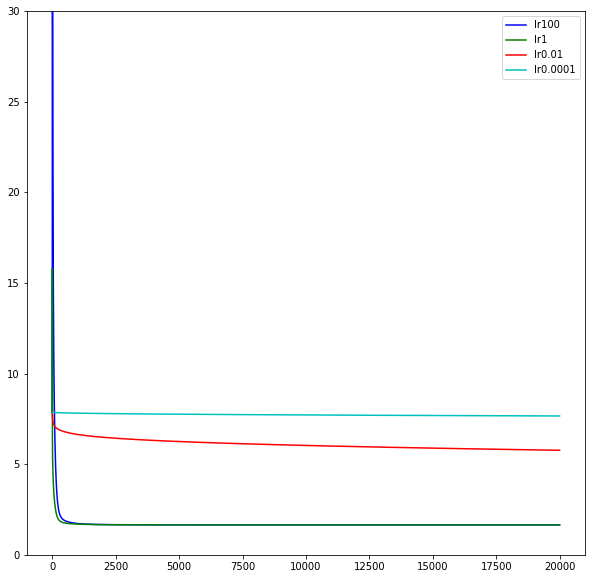

In [33]:
w_ada, L1 = ada(x_train_set,y_train_set,w=w_int ,learning_rate=100,iter_time=20000,lambdaL2=0,eps=0.0000000001)
w_ada, L2 = ada(x_train_set,y_train_set,w=w_int ,learning_rate=1,iter_time=20000,lambdaL2=0,eps=0.0000000001)
w_ada, L3 = ada(x_train_set,y_train_set,w=w_int ,learning_rate=0.01,iter_time=20000,lambdaL2=0,eps=0.0000000001)
w_ada, L4 = ada(x_train_set,y_train_set,w=w_int ,learning_rate=0.0001,iter_time=20000,lambdaL2=0,eps=0.0000000001)
plt.figure(figsize=(10,10))
plt.plot(range(iter_time),L1,'b',label="lr100")
plt.plot(range(iter_time),L2,'g',label="lr1")
plt.plot(range(iter_time),L3,'r',label="lr0.01")
plt.plot(range(iter_time),L4,'c',label="lr0.0001")
plt.ylim(0,30)
plt.legend()

# Different gradient mode

GD:
0:7.863392795150797
9999:3.208201608517956
19998:2.2467266880608565
Ada:
0:7.863392795150797
9999:1.6511393223620263
19998:1.6506837995265407


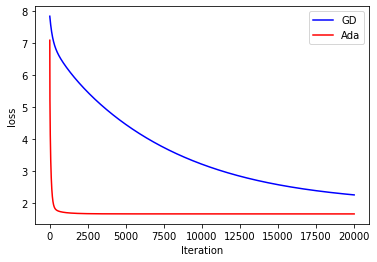

In [34]:
from numpy.linalg import inv
#close form
w_cf = inv(x_train_set.T.dot(x_train_set)).dot(x_train_set.T).dot(y_train_set)
cost_wcf = np.sum((x_train_set.dot(w_cf)-y_train_set)**2) / len(x_train_set)
hori = [cost_wcf for i in range(20000-3)]
#plt.plot(np.arange(len(cost_list_ada[3:])), hori, 'y--', label='close-form')

#GD

w_GD, cost_list_GD = GD(x_train_set,y_train_set,w = w_int,learning_rate=0.0001,iter_time=20000,lambdaL2=0)
plt.plot(range(len(cost_list_GD[3:])), cost_list_GD[3:],'b',label ="GD")

#ADA

w_ada, cost_list_ada = ada(x_train_set,y_train_set,w = w_int,learning_rate=1,eps=0.0000000001,iter_time=20000,lambdaL2=0)
plt.plot(range(len(cost_list_ada[3:])), cost_list_ada[3:],'r',label ="Ada")



plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()

# **Testing**
![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [35]:
# testdata = pd.read_csv('gdrive/My Drive/hw1-regression/test.csv', header = None, encoding = 'big5')
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
#test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x.shape



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


(240, 162)

# **Prediction**
說明圖同上

![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

有了 weight 和測試資料即可預測 target。

In [36]:
test_x = np.concatenate((np.ones((test_x.shape[0],1)),test_x), axis=1)
test_x.shape

(240, 163)

In [37]:
ans_y = np.dot(test_x, w_ada)
ans_y.shape

(240, 1)

# **Save Prediction to CSV File**


In [38]:
import csv
with open('submit1.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 7.047018044749682]
['id_1', 18.310718300496895]
['id_2', 24.43718832940402]
['id_3', 7.055197844272635]
['id_4', 27.214475186319984]
['id_5', 22.41567433803765]
['id_6', 24.184737221223706]
['id_7', 30.893500246197902]
['id_8', 16.764560494680055]
['id_9', 60.169173298927184]
['id_10', 11.882911668731783]
['id_11', 8.981548265668478]
['id_12', 63.014504748951005]
['id_13', 53.66145529829923]
['id_14', 21.745387579808146]
['id_15', 12.291700832421478]
['id_16', 32.379970555223515]
['id_17', 66.14524759617393]
['id_18', -0.9644420390016237]
['id_19', 17.184664559810866]
['id_20', 41.673939193519224]
['id_21', 72.05681231092773]
['id_22', 8.781157983546022]
['id_23', 17.78001429311745]
['id_24', 14.656476032949218]
['id_25', 38.45076189923014]
['id_26', 14.434369007321255]
['id_27', 68.98119212242055]
['id_28', 6.822755212175866]
['id_29', 55.96505001641858]
['id_30', 24.526285123573807]
['id_31', 9.291039699016913]
['id_32', 3.377684550371449]
['id_33', 18.943673

相關 reference 可以參考:

Adagrad :
https://youtu.be/yKKNr-QKz2Q?list=PLJV_el3uVTsPy9oCRY30oBPNLCo89yu49&t=705 

RMSprop : 
https://www.youtube.com/watch?v=5Yt-obwvMHI 

Adam
https://www.youtube.com/watch?v=JXQT_vxqwIs 


以上 print 的部分主要是為了看一下資料和結果的呈現，拿掉也無妨。另外，在自己的 linux 系統，可以將檔案寫死的的部分換成 sys.argv 的使用 (可在 terminal 自行輸入檔案和檔案位置)。

最後，可以藉由調整 learning rate、iter_time (iteration 次數)、取用 features 的多寡(取幾個小時，取哪些特徵欄位)，甚至是不同的 model 來超越 baseline。

Report 的問題模板請參照 : https://docs.google.com/document/d/1s84RXs2AEgZr54WCK9IgZrfTF-6B1td-AlKR9oqYa4g/edit